# Нейронные сети
__Суммарное количество баллов: 10__

В этом домашнем задании можно использовать готовые классы библиотек PyTorch, Keras, TensorFlow.

In [11]:
import torch
import random
import numpy as np
import pandas as pd
import torchvision.datasets
from sklearn.model_selection import train_test_split
from math import sqrt
from time import time
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

### Задание 1 (4 балла)

Создайте сеть из трех сверточных слоев по 8 сверток 3х3 и двух полносвязных слоев по 64 нейрона. 

Обучите сеть на датасете mnist с тремя разными функциями активации в слоях (sigmoid, tanh, ReLU).

#### Самый главный класс:
У нас на вход 28x28 и надо чтобы ядро было 3x3 и сверток 8 и сделать это надо за три слоя сверточных (потом обычные пойдут).

Я просто поэкспериментировал, и получил рабочую штуку:


* 1й слой: ядро 3x3, паддинг шириной 1. Получаем на выходе также 28x8 изображение. И применяем к нему стандартный пуллинг: 2x2 с шагом 2 , получаем 14x14.
* 2й слой: ядро 3x3, паддинг шириной 2 => на выходе 16x16. Пулинг опять стандартный 2x2 с шагом 2 => 8x8 изображение
* 3й слой: ядро 3x3, паддинг шириной 1 => на выходе также 8x8 изображение. Теперь пулинг 4x4 и страйдом 2 и 4, чтобы получить 8 "пикселей".
Теперь все просто, 8 сверток, в каждой по 8 фичей, прогоним через два полносвязных слоев по 64 нейрона и получим ответ.

In [2]:
def get_activation(activation_type = 'relu'):
    if activation_type == 'tanh':
        return torch.nn.Tanh()
    if activation_type == 'sigmoid':
        return torch.nn.Sigmoid()
    else:
        return torch.nn.ReLU()
    

class TohaNet(torch.nn.Module):
    def __init__(self, activation_type = 'relu'):
        super(TohaNet, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=8, kernel_size=3, padding=1)
        self.act1  = get_activation(activation_type = activation_type)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=8, out_channels=8, kernel_size=3, padding=2)
        self.act2  = get_activation(activation_type)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
       
        self.conv3 = torch.nn.Conv2d(
            in_channels=8, out_channels=8, kernel_size=3, padding=1)
        self.act3  = get_activation(activation_type)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=(2, 2))
        
        
        self.fc1   = torch.nn.Linear(4*4*8, 64)
        self.act4  = get_activation(activation_type)
        
        self.fc2   = torch.nn.Linear(64, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act4(x)
        x = self.fc2(x)
        
        return x

Теперь прочитаем и обработаем файлик:

In [3]:
def numpy_2d_from_1d(array):
    n = int(sqrt(len(array)))
    i = 0
    answer_array = []
    while (i < n*n):
        answer_array.append(array[i:i+n])
        i+=n
    return answer_array

def from_X_to_torch(X):
    final_array = []
    for index, row in X.iterrows():
        final_array.append(numpy_2d_from_1d(row.values))
    return torch.tensor(final_array)

def read_spam_dataset(path_to_csv):
    data = pd.read_csv(path_to_csv)
    X = data.drop("label", axis=1)
    y = data.label
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)
    X_train = from_X_to_torch(X_train)
    X_test = from_X_to_torch(X_test)
    y_train = torch.tensor(y_train.values)
    y_test = torch.tensor(y_test.values)
    # Это нужно, чтобы появились "каналы"
    X_train = X_train.unsqueeze(1).float()
    X_test = X_test.unsqueeze(1).float()
    return X_train, X_test, y_train, y_test

Главная функция, которая будет обучать:

In [4]:
def run(activation:str, X_train, X_test, y_train, y_test, not_mnist = False):
    tic = time()
    try:
        if not_mnist:
            tohaNet = TohaNet_2(activation)
        else:
            tohaNet = TohaNet(activation)
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        tohaNet = tohaNet.to(device)

        # Лосс - кросс-энтропия, потому что классификация
        # Градиентный спуск - Адам
        loss = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(tohaNet.parameters(), lr=1.0e-3)


        batch_size = 50

        test_accuracy_history = []
        test_loss_history = []

        X_test = X_test.to(device)
        y_test = y_test.to(device)

        for epoch in range(10000):
            order = np.random.permutation(len(X_train))
            for start_index in range(0, len(X_train), batch_size):
                optimizer.zero_grad()

                batch_indexes = order[start_index:start_index+batch_size]

                X_batch = X_train[batch_indexes].to(device)
                y_batch = y_train[batch_indexes].to(device)

                preds = tohaNet.forward(X_batch) 

                loss_value = loss(preds, y_batch)
                loss_value.backward()

                optimizer.step()

            test_preds = tohaNet.forward(X_test)
            test_loss_history.append(loss(test_preds, y_test).data.cpu())

            accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
            test_accuracy_history.append(accuracy)

            print(accuracy)
    except KeyboardInterrupt:
        print('Время обучения: '+str(time()-tic))
        print('Изменение accuracy по эпохам:')
        plt.plot(test_accuracy_history)
        plt.show()
        
        print('Изменение loss_function по эпохам:')
        plt.plot(test_loss_history)
        plt.show()

In [215]:
X_train, X_test, y_train, y_test = read_spam_dataset('data/mnist_notmnist/mnist.csv')

In [216]:
X_train.shape

torch.Size([8000, 1, 28, 28])

In [217]:
y_train.shape

torch.Size([8000])

Быстренькая проверка, что все идет по плану:

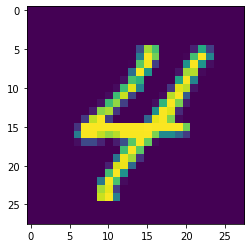

tensor(4)


In [94]:

plt.imshow(X_train[0, 0, :, :])
plt.show()
print(y_train[0])

Запущу, и остановлю на том accuracy, когда +- все будет уже осциллировать:
1. sigmoid

tensor(0.1285)
tensor(0.1375)
tensor(0.3980)
tensor(0.6240)
tensor(0.6950)
tensor(0.7865)
tensor(0.8290)
tensor(0.8525)
tensor(0.8710)
tensor(0.8855)
tensor(0.8990)
tensor(0.9095)
tensor(0.9150)
tensor(0.9180)
tensor(0.9275)
tensor(0.9250)
tensor(0.9345)
tensor(0.9385)
tensor(0.9445)
tensor(0.9420)
tensor(0.9490)
tensor(0.9510)
tensor(0.9505)
tensor(0.9540)
tensor(0.9555)
tensor(0.9605)
tensor(0.9610)
tensor(0.9575)
Время обучения: 96.1299557685852
Изменение accuracy по эпохам:


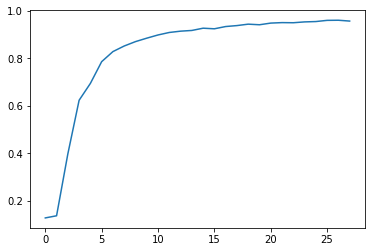

Изменение loss_function по эпохам:


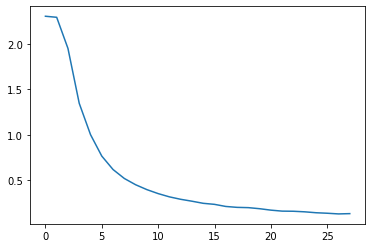

In [99]:
run('sigmoid', X_train, X_test, y_train, y_test)

2. tanh

tensor(0.8215)
tensor(0.8865)
tensor(0.9175)
tensor(0.9300)
tensor(0.9380)
tensor(0.9465)
tensor(0.9480)
tensor(0.9585)
tensor(0.9495)
tensor(0.9570)
tensor(0.9585)
tensor(0.9580)
tensor(0.9640)
tensor(0.9585)
tensor(0.9585)
tensor(0.9595)
tensor(0.9630)
tensor(0.9630)
Время обучения: 63.89311218261719
Изменение accuracy по эпохам:


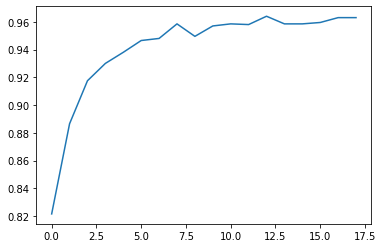

Изменение loss_function по эпохам:


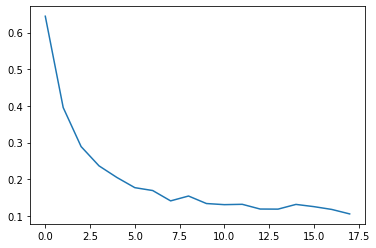

In [100]:
run('tanh', X_train, X_test, y_train, y_test)

3. relu

tensor(0.9265)
tensor(0.9460)
tensor(0.9450)
tensor(0.9530)
tensor(0.9490)
tensor(0.9620)
tensor(0.9665)
tensor(0.9665)
tensor(0.9665)
tensor(0.9670)
tensor(0.9600)
tensor(0.9705)
tensor(0.9705)
Время обучения: 45.5383186340332
Изменение accuracy по эпохам:


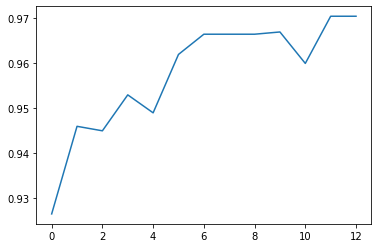

Изменение loss_function по эпохам:


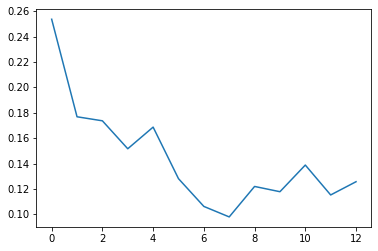

In [101]:
run('relu', X_train, X_test, y_train, y_test)

### Задание 2 (6 баллов)

Достигните точности 87% на test датасете notMNIST.

Архитектура сети может быть любая. Можно использовать Data Augmentation.

In [5]:
def images_to_tensor(path:str):
    data = torchvision.datasets.ImageFolder(root = path, transform=torchvision.transforms.ToTensor())
    data_loader = torch.utils.data.DataLoader(data, batch_size=int(len(data)/2), shuffle=True, num_workers=8)
    return data_loader

def array_to_datasets(tensor_array):
    test = True
    for array in tensor_array:
        if test:
            test = False
            X_test = array[0]
            y_test = array[1]
        else:
            X_train = array[0]
            y_train = array[1]
    
    return X_train, X_test, y_train, y_test

In [18]:
class TohaNet_2(torch.nn.Module):
    def __init__(self, activation_type = 'relu'):
        super(TohaNet_2, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.act1  = get_activation(activation_type = activation_type)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=8, out_channels=8, kernel_size=3, padding=2)
        self.act2  = get_activation(activation_type)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
       
        self.conv3 = torch.nn.Conv2d(
            in_channels=8, out_channels=8, kernel_size=3, padding=1)
        self.act3  = get_activation(activation_type)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=(2, 2))
        
        
        self.fc1   = torch.nn.Linear(4*4*8, 64)
        self.act4  = get_activation(activation_type)
        
        self.fc2   = torch.nn.Linear(64, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act4(x)
        x = self.fc2(x)
        
        return x

In [7]:
tensor_array = images_to_tensor('data/mnist_notmnist/notMNIST_small')
X_train, X_test, y_train, y_test = array_to_datasets(tensor_array)

tensor(0.8480)
tensor(0.8900)
tensor(0.8897)
tensor(0.9025)
tensor(0.9018)
tensor(0.9107)
tensor(0.9112)
tensor(0.9147)
tensor(0.9210)
tensor(0.9168)
tensor(0.9172)
tensor(0.9257)
tensor(0.9199)
tensor(0.9252)
Время обучения: 53.65597367286682
Изменение accuracy по эпохам:


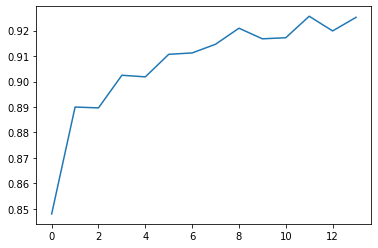

Изменение loss_function по эпохам:


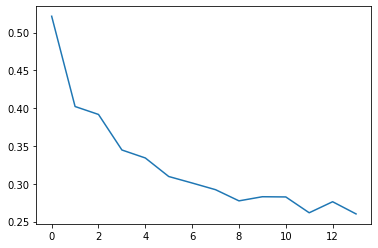

In [19]:
run('relu', X_train, X_test, y_train, y_test, not_mnist = True)